## **Validation**

### **Set Environment**

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
from lib.QuantumCalculator import LaplacianEVProcessor2D, InnerProductProcessor
from lib.classical_functions import *
from lib.quantum_functions import *
import os

# IonQ Simulator
os.environ['IONQ_API_KEY'] = 'BU5YwsZpbahvhbxSOEc9qMCvyCqhmxq8'
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

QiskitRuntimeService.delete_account()
QiskitRuntimeService.save_account(instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/a9b97467e1764d528c81e4fb88381d3e:8a23c223-141b-472f-8cee-c497a4d54a84::', token = 'EiR9t2RL5Z6lVdYcnUfwtQHgmIRq04i0_gGXAfG6KeD1', set_as_default=True, overwrite=True)
hardware_backend = QiskitRuntimeService().least_busy()
print(hardware_backend.name)

ibm_yonsei


### **Initialize Sampler**

In [3]:
grid_num = 512
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Design Ansatz**

Number of Parameters: 36


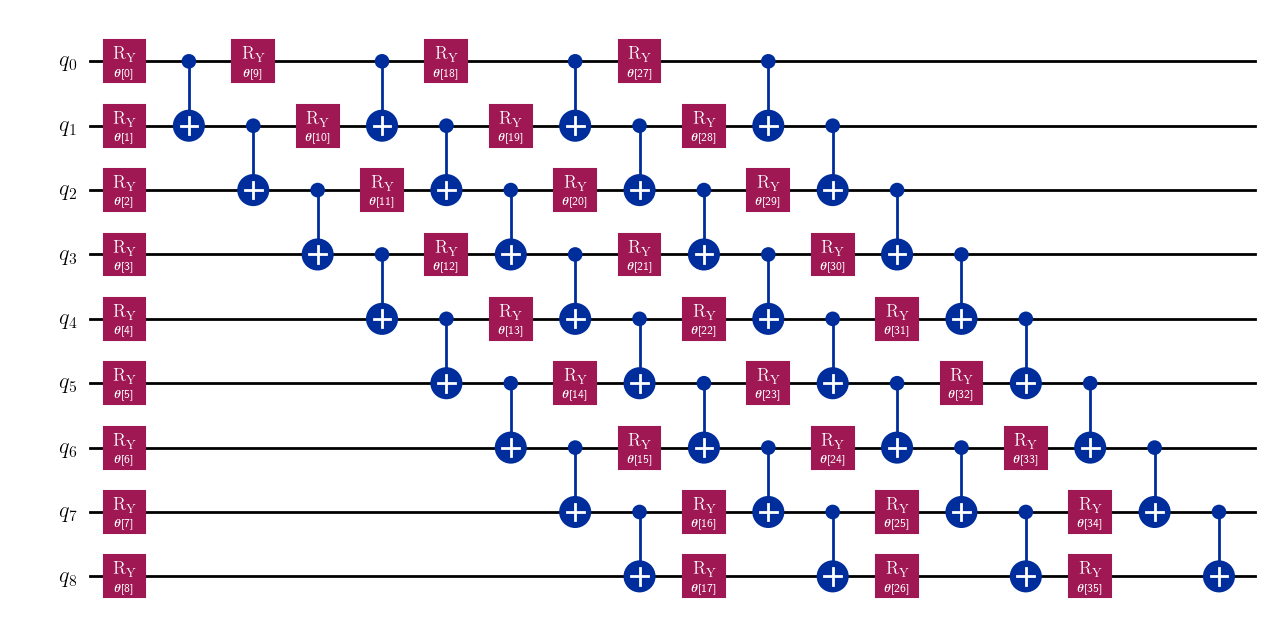

In [4]:
num_qubits = int(np.log2(grid_num))
ansatz_depth = 4
param_num = num_qubits * ansatz_depth
parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

psi_param_circuit = make_LNN_ansatz(num_qubits, ansatz_depth, parameters)
print(f"Number of Parameters: {param_num}")
psi_param_circuit.draw('mpl', fold = -1)

### **Fill input_2D**

In [10]:
def source(x,y):
    return -8 * np.pi * np.pi * np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)
def analytic_sol(x,y):
    return np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)

x0 = -1
x1 = 1
y0 = 0
y1 = 1
x_grid_num = 32
y_grid_num = 16
x_grid = np.linspace(x0, x1, x_grid_num + 2, endpoint = True)
x_grid = x_grid[1:-1]

y_grid = np.linspace(y0, y1, y_grid_num + 2, endpoint = True)
y_grid = y_grid[1:-1]

rhs = np.zeros((32, 16))
exact = np.zeros((32, 16))
for i in range (x_grid_num):
    for j in range (y_grid_num):
        rhs[i,j] = source(x_grid[i], y_grid[j])
        exact[i,j] = analytic_sol(x_grid[i], y_grid[j])
        
        
# np.savetxt("input_2D/rhs.csv", rhs, delimiter=",")
exact_normalized = exact / np.linalg.norm(exact)

# initial_params = np.random.rand(param_num) * 4 * np.pi
# np.savetxt("input_2D/initial_params.csv", initial_params, delimiter = ",")

In [4]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, LaplacianEVProcessor2D, InnerProductProcessor
from lib.QuantumOptimizer import VQA_PoissonOptimizer
from lib.classical_functions import *
from lib.quantum_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import yaml

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# ================================
# Load Configuration
# ================================
print("Loading configuration from config.yaml...")
with open("input_2D/config.yaml", "r") as file:
    config = yaml.safe_load(file)

x0 = config["x0"]
x1 = config["x1"]

y0 = config["y0"]
y1 = config["y1"]

x_grid_num = config["x_grid_num"]
y_grid_num = config["y_grid_num"]

dx = (x1 - x0) / (x_grid_num + 1)
dy = (y1 - y0) / (y_grid_num + 1)

ansatz_depth = config["ansatz_depth"]
boundary_condition = config["boundary_condition"]
num_shots = config["num_shots"]
backend = config["backend"]
method = config["method"]

# ================================
# Backend Setup
# ================================
print("Initializing backends...")
if backend == 'simulator':
    # IonQ Simulator
    # os.environ['IONQ_API_KEY'] = 'Your API Key'
    provider = IonQProvider(os.getenv("IONQ_API_KEY"))
    simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
    simulator_backend.set_options(noise_model="ideal")
    
    print(f"Using IonQ simulator: {simulator_backend.name()}")
    used_backend = simulator_backend
    is_simulator = True
    sampler = None
    
elif backend == 'hardware':
    hardware_backend = QiskitRuntimeService().least_busy()
    print(f"Using IBM hardware: {hardware_backend.name}")
    
    # IBM Hardware
    used_backend = hardware_backend
    options_sampler = SamplerOptions()
    options_sampler.default_shots = num_shots
    sampler = Sampler(mode = hardware_backend, options = options_sampler)
    is_simulator = False
else:
    raise ValueError("Invalid backend specified in config.yaml. Choose either 'simulator' or 'hardware'.")

print(f"Configuration:")
print(f"  - x0: {x0}")
print(f"  - x1: {x1}")
print(f"  - x_grid_num: {x_grid_num}")
print(f"  - y_grid_num: {y_grid_num}")
grid_num = x_grid_num * y_grid_num
print(f"  - Total grid_num: {grid_num}")
print(f"  - boundary_condition: {boundary_condition}")

num_qubits = int(np.log2(grid_num))
param_num = num_qubits * ansatz_depth

print(f"  - num_qubits: {num_qubits}, make sure 2 ^ {num_qubits} = grid_num")
print(f"  - ansatz_depth: {ansatz_depth}")
print(f"  - num_shots: {num_shots}")
print(f"  - backend: {backend}")
print(f"  - optimization method: {method}")

parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)
psi_param_circuit = make_LNN_ansatz(num_qubits, ansatz_depth, parameters)

print("Parameterized circuit constructed.")
print(f"  - Number of qubits: {psi_param_circuit.num_qubits}")
print(f"  - Number of parameters: {len(psi_param_circuit.parameters)}")
f_vector = np.loadtxt("input_2D/rhs.csv", delimiter=",")
alpha_x = 0.0
beta_x = 0.0
gamma_x = 0.0

# If Robin along x direction
if boundary_condition[0] == "R":
    alpha_x = config['alpha_x']
    beta_x = config['beta_x']
    gamma_x = config['gamma_x']
    
    print(f"  - Robin boundary condition used along x direction -- alpha_x = {alpha_x}, beta_x = {beta_x}, gamma_x = {gamma_x}")
    print("  - Please make sure the following is satisfied in your PDE:")
    print(r"  - $\alpha_x U_0i + \beta_x \frac{\partial U_0i}{\partial n} = \gamma_x$")
    print(r"  - $\alpha_x U_Ni - \beta_x \frac{\partial U_Ni}{\partial n} = \gamma_x$")
    
    # Dirichlet Correction
    if gamma_x != 0.0:
        for i in range (y_grid_num):
            f_vector[0,i] = f_vector[0,i] - (gamma_x / (alpha_x - (beta_x / dx))) / (dx * dx)
            f_vector[x_grid_num - 1, i] = f_vector[x_grid_num - 1, i] - (gamma_x / (alpha_x - (beta_x / dx))) / (dx * dx)
    alpha_y = 0.0
    beta_y = 0.0
    gamma_y = 0.0
         
# If Robin along y direction   
if boundary_condition[1] == "R":
    alpha_y = config['alpha_y']
    beta_y = config['beta_y']
    gamma_y = config['gamma_y']
    
    print(f"  - Robin boundary condition used along y direction -- alpha_y = {alpha_y}, beta_y = {beta_y}, gamma_y = {gamma_y}")
    print("  - Please make sure the following is satisfied in your PDE:")
    print(r"  - $\alpha_y U_i0 + \beta_y \frac{\partial U_i0}{\partial n} = \gamma_y$")
    print(r"  - $\alpha_y U_iN - \beta_y \frac{\partial U_iN}{\partial n} = \gamma_y$")
    
    # Dirichlet Correction
    if gamma_y != 0.0:
        for i in range (x_grid_num):
            f_vector[i, 0] = f_vector[i, 0] - (gamma_y / (alpha_y - (beta_y / dy))) / (dy * dy)
            f_vector[i, y_grid_num - 1] = f_vector[i, y_grid_num - 1] - (gamma_y / (alpha_y - (beta_y / dy))) / (dy * dy)
            
laplacian_processor = LaplacianEVProcessor2D(ansatz_list = [psi_param_circuit],
                                             boundary_condition_list = [boundary_condition],
                                             x_qubit_counts_list = [int(np.log2(x_grid_num))],
                                             dx_list = [dx],
                                             dy_list = [dy],
                                             backend = used_backend,
                                             num_shots = num_shots,
                                             is_simulator = is_simulator,
                                             alpha_x = alpha_x,
                                             alpha_y = alpha_y,
                                             beta_x = beta_x,
                                             beta_y = beta_y
                                             )
A_x = laplacian_matrix(n = x_grid_num,
                       boundary_condition = boundary_condition[0],
                       alpha = alpha_x,
                       beta = beta_x,
                       dx = dx)

A_y = laplacian_matrix(n = y_grid_num,
                       boundary_condition = boundary_condition[1],
                       alpha = alpha_y,
                       beta = beta_y,
                       dx = dy)

A = np.kron(np.eye(y_grid_num), A_x) + np.kron(A_y, np.eye(x_grid_num))
check_stability(A, num_shots)

f_vector = f_vector.flatten()
f_normalized = f_vector / np.linalg.norm(f_vector)

numerator_processor = InnerProductProcessor(
        ansatz_list=[psi_param_circuit],
        numerator_list = [f_normalized],
        backend = used_backend,
        num_shots = num_shots,
        is_simulator = is_simulator,
        sampler = sampler
    )

# ================================
# Optimization
# ================================
print("🚀 Starting optimization...")

optimizer = VQA_PoissonOptimizer(
            laplacian_processor = laplacian_processor,
            numerator_processor = numerator_processor)

initial_params = np.loadtxt("input_2D/initial_params.csv", delimiter=",")

result = optimizer.optimize(
            initial_params = initial_params,
            method = method
            )

print("Optimization complete.")

# ================================
# Get Amplitude
# ================================
amplitudes = optimizer.get_amplitudes(optimal_params = result.x)

os.makedirs("output_2D", exist_ok=True)
np.savetxt("output_2D/VQA_optimal_parameters.csv", result.x, delimiter=",")
np.savetxt("output_2D/VQA_optimal_amplitudes.csv", amplitudes, delimiter=",")

with open("output_2D/VQA_result.txt", "w") as f:
    print(result, file=f)
    
print("Results saved to:")
print("  - output_2D/VQA_optimal_parameters.csv")
print("  - output_2D/VQA_optimal_amplitudes.csv")
print("  - output_2D/VQA_result.txt")

Loading configuration from config.yaml...
Initializing backends...
Using IonQ simulator: ionq_simulator
Configuration:
  - x0: 0.0
  - x1: 1.0
  - x_grid_num: 32
  - y_grid_num: 16
  - Total grid_num: 512
  - boundary_condition: PR
  - num_qubits: 9, make sure 2 ^ 9 = grid_num
  - ansatz_depth: 4
  - num_shots: 524288
  - backend: simulator
  - optimization method: Powell
Parameterized circuit constructed.
  - Number of qubits: 9
  - Number of parameters: 36
  - Robin boundary condition used along y direction -- alpha_y = 0.0, beta_y = 0.0, gamma_y = 0.0
  - Please make sure the following is satisfied in your PDE:
  - $\alpha_y U_i0 + \beta_y \frac{\partial U_i0}{\partial n} = \gamma_y$
  - $\alpha_y U_iN - \beta_y \frac{\partial U_iN}{\partial n} = \gamma_y$
  - Matrix is well-conditioned. Minimum |<ψ|A|ψ>| = 3.405e-02

🚀 Starting optimization...


c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying retrieve_job after IonQRetriableError('Unknown error')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying submit_job 4 more time(s) after IonQRetriableError('An invalid response was received from the upstream server')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying retrieve_job after IonQRetriableError('Unknown error')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying get_results after IonQRetriableError('No error details provided.')
  warnings.warn(


Optimization complete.
Results saved to:
  - output_2D/VQA_optimal_parameters.csv
  - output_2D/VQA_optimal_amplitudes.csv
  - output_2D/VQA_result.txt


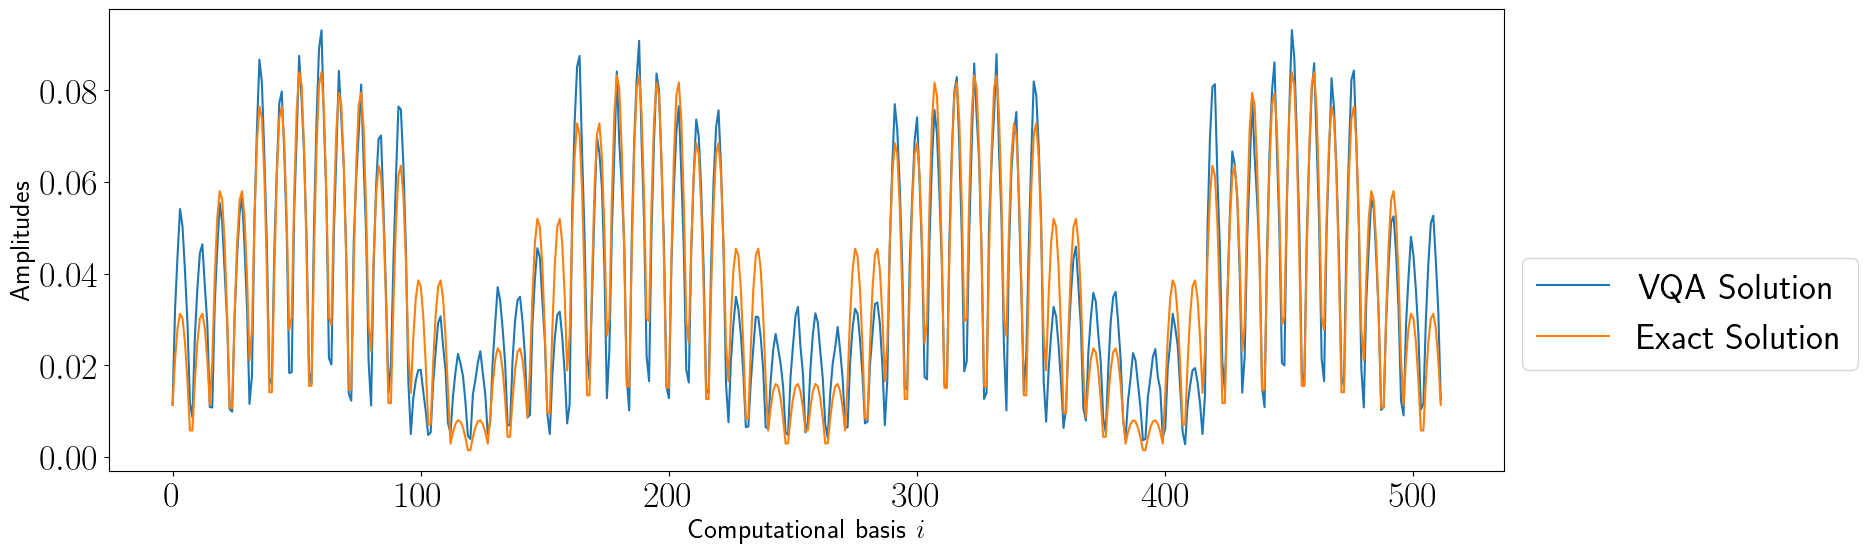

In [28]:
plt.figure(figsize = (18,6))
plt.plot(amplitudes, label = 'VQA Solution')
plt.plot(np.abs(exact_normalized.flatten()), label = 'Exact Solution')
plt.xlabel(r'Computational basis $i$', fontsize = 20)
plt.ylabel("Amplitudes", fontsize = 20)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.legend(fontsize = 26, bbox_to_anchor = (1,0.5))
plt.show()